In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates

In [4]:
# Load the datasets
episodes_path = "data/power_rangers_episodes.csv"
seasons_path = "data/power_rangers_seasons.csv"

episodes_df = pd.read_csv(episodes_path)
seasons_df = pd.read_csv(seasons_path)

# Display basic information and first few rows of each dataset
episodes_info = episodes_df.info(), episodes_df.head()
seasons_info = seasons_df.info(), seasons_df.head()

episodes_info, seasons_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_title   921 non-null    object 
 1   episode_num    921 non-null    int64  
 2   episode_title  921 non-null    object 
 3   air_date       921 non-null    object 
 4   IMDB_rating    921 non-null    float64
 5   total_votes    921 non-null    int64  
 6   desc           921 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 50.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   season_title        28 non-null     object 
 1   season_num          28 non-null     int64  
 2   number_of_episodes  28 non-null     int64  
 3   air_date_first_ep   28 non-null     object 
 4   air_date_last_ep    28 non-null     

((None,
                  season_title  episode_num          episode_title    air_date  \
  0  Mighty Morphin (Season 1)            0       The Lost Episode  1999-05-22   
  1  Mighty Morphin (Season 1)            1    Day of the Dumpster  1993-08-28   
  2  Mighty Morphin (Season 1)            2              High Five  1993-09-04   
  3  Mighty Morphin (Season 1)            3               Teamwork  1993-09-08   
  4  Mighty Morphin (Season 1)            4  A Pressing Engagement  1993-09-09   
  
     IMDB_rating  total_votes                                               desc  
  0          6.7          113          Original version of the premiere episode.  
  1          7.4          687  Following the accidental release of long-impri...  
  2          6.9          564  Rita plans to trap the Rangers in a time trap ...  
  3          7.3          546  Trini and Kimberly set up a petition to clean ...  
  4          6.9          535  Jason is trying to break the bench press recor...  

In [15]:
# Convert air dates to datetime format
seasons_df['air_date_first_ep'] = pd.to_datetime(seasons_df['air_date_first_ep'])
seasons_df['air_date_last_ep'] = pd.to_datetime(seasons_df['air_date_last_ep'], errors='coerce')  # Handle '2022' which is not a complete date

# Create a column for season duration in days
seasons_df['season_duration'] = (seasons_df['air_date_last_ep'] - seasons_df['air_date_first_ep']).dt.days

# Create a column for gap between seasons (days since previous season ended)
seasons_df['days_since_previous'] = (seasons_df['air_date_first_ep'] - seasons_df['air_date_last_ep'].shift(1)).dt.days



In [14]:
# Create a column for the era (decade) of the show
seasons_df['era'] = seasons_df['air_date_first_ep'].dt.year // 10 * 10
seasons_df['era'] = seasons_df['era'].astype(str) + 's'

# Create a column for season length category
seasons_df['season_length_category'] = pd.cut(seasons_df['number_of_episodes'], 
                                     bins=[0, 30, 45, 60], 
                                     labels=['Short (≤30)', 'Medium (31-45)', 'Long (46-60)'])


In [16]:

# Create a function to analyze and visualize the factors influencing popularity
def analyze_popularity_factors(data):
    """
    Analyze factors that may influence the popularity (IMDB rating) of Power Rangers seasons.
    
    Args:
        data (DataFrame): Power Rangers seasons data
    """
    # Set the style for plots
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Producer vs Rating
    ax1 = axes[0, 0]
    producer_ratings = data.groupby('producer')['IMDB_rating'].mean().sort_values(ascending=False)
    producer_counts = data.groupby('producer').size()
    
    sns.barplot(x=producer_ratings.index, y=producer_ratings.values, ax=ax1, palette='viridis')
    ax1.set_title('Average IMDB Rating by Producer', fontsize=16)
    ax1.set_xlabel('Producer', fontsize=14)
    ax1.set_ylabel('Average IMDB Rating', fontsize=14)
    
    # Add count annotations
    for i, v in enumerate(producer_ratings.values):
        ax1.text(i, v + 0.05, f"n={producer_counts[producer_ratings.index[i]]}", 
                 ha='center', fontsize=12)
    
    # 2. Number of Episodes vs Rating
    ax2 = axes[0, 1]
    sns.scatterplot(data=data, x='number_of_episodes', y='IMDB_rating', 
                   hue='producer', size='season_num', sizes=(50, 200), 
                   alpha=0.7, ax=ax2, palette='viridis')
    
    # Add regression line
    sns.regplot(data=data, x='number_of_episodes', y='IMDB_rating', 
               scatter=False, ax=ax2, color='red', line_kws={"linestyle": "--"})
    
    # Calculate correlation
    corr = data['number_of_episodes'].corr(data['IMDB_rating'])
    ax2.set_title(f'Episodes vs Rating (Correlation: {corr:.2f})', fontsize=16)
    ax2.set_xlabel('Number of Episodes', fontsize=14)
    ax2.set_ylabel('IMDB Rating', fontsize=14)
    
    # 3. Season Length Category vs Rating
    ax3 = axes[1, 0]
    sns.boxplot(data=data, x='season_length_category', y='IMDB_rating', ax=ax3, palette='viridis')
    ax3.set_title('IMDB Ratings by Season Length Category', fontsize=16)
    ax3.set_xlabel('Season Length', fontsize=14)
    ax3.set_ylabel('IMDB Rating', fontsize=14)
    
    # Add count annotations
    for i, category in enumerate(data['season_length_category'].unique()):
        count = len(data[data['season_length_category'] == category])
        mean = data[data['season_length_category'] == category]['IMDB_rating'].mean()
        ax3.text(i, data['IMDB_rating'].min() - 0.15, f"n={count}", ha='center', fontsize=12)
    
    # 4. Time Series of Ratings
    ax4 = axes[1, 1]
    sns.scatterplot(data=data, x='air_date_first_ep', y='IMDB_rating', 
                   hue='producer', size='number_of_episodes', sizes=(50, 200),
                   alpha=0.7, ax=ax4, palette='viridis')
    
    # Add a line to show trend over time
    sns.regplot(data=data, x=mdates.date2num(data['air_date_first_ep']), y='IMDB_rating', 
               scatter=False, ax=ax4, color='red', line_kws={"linestyle": "--"})
    
    # Format x-axis to show years
    years = mdates.YearLocator(2)  # show ticks every 2 years
    years_fmt = mdates.DateFormatter('%Y')
    ax4.xaxis.set_major_locator(years)
    ax4.xaxis.set_major_formatter(years_fmt)
    
    ax4.set_title('IMDB Ratings Over Time', fontsize=16)
    ax4.set_xlabel('First Episode Air Date', fontsize=14)
    ax4.set_ylabel('IMDB Rating', fontsize=14)
    
    plt.tight_layout()
    
    # Additional Analysis: Gap Between Seasons vs Rating
    plt.figure(figsize=(12, 8))
    
    # Filter out NaN values in days_since_previous
    gap_data = data.dropna(subset=['days_since_previous'])
    
    # Create scatter plot
    sns.scatterplot(data=gap_data, x='days_since_previous', y='IMDB_rating', 
                   hue='producer', size='season_num', sizes=(50, 200), 
                   alpha=0.7, palette='viridis')
    
    # Add regression line
    sns.regplot(data=gap_data, x='days_since_previous', y='IMDB_rating', 
               scatter=False, color='red', line_kws={"linestyle": "--"})
    
    # Calculate correlation
    gap_corr = gap_data['days_since_previous'].corr(gap_data['IMDB_rating'])
    plt.title(f'Days Since Previous Season vs Rating (Correlation: {gap_corr:.2f})', fontsize=16)
    plt.xlabel('Days Since Previous Season Ended', fontsize=14)
    plt.ylabel('IMDB Rating', fontsize=14)
    
    # Find the top 5 highest rated seasons
    top_seasons = data.sort_values('IMDB_rating', ascending=False).head(5)
    print("Top 5 Highest Rated Seasons:")
    print(top_seasons[['season_title', 'season_num', 'IMDB_rating', 'producer', 'number_of_episodes']])
    
    # Find the lowest 5 rated seasons
    bottom_seasons = data.sort_values('IMDB_rating').head(5)
    print("\nBottom 5 Lowest Rated Seasons:")
    print(bottom_seasons[['season_title', 'season_num', 'IMDB_rating', 'producer', 'number_of_episodes']])
    
    # Compare early seasons (1-10) with later seasons (11-28)
    early = data[data['season_num'] <= 10]
    later = data[data['season_num'] > 10]
    
    print("\nEarly Seasons (1-10) Average Rating:", early['IMDB_rating'].mean())
    print("Later Seasons (11-28) Average Rating:", later['IMDB_rating'].mean())
    
    # Statistical test: Are the differences significant?
    from scipy import stats
    t_stat, p_val = stats.ttest_ind(early['IMDB_rating'], later['IMDB_rating'])
    print(f"T-test result: t={t_stat:.2f}, p={p_val:.3f}")
    if p_val < 0.05:
        print("The difference in ratings between early and later seasons is statistically significant.")
    else:
        print("The difference in ratings between early and later seasons is not statistically significant.")
    
    return data

C:\Users\FPT SHOP\AppData\Local\Temp\ipykernel_22064\1451220459.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=producer_ratings.index, y=producer_ratings.values, ax=ax1, palette='viridis')
C:\Users\FPT SHOP\AppData\Local\Temp\ipykernel_22064\1451220459.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='season_length_category', y='IMDB_rating', ax=ax3, palette='viridis')


Top 5 Highest Rated Seasons:
                 season_title  season_num  IMDB_rating      producer  \
5                    In Space           6          7.3         Saban   
8                  Time Force           9          7.1         Saban   
6                 Lost Galaxy           7          6.9         Saban   
27                  Dino Fury          28          6.8  Saban Brands   
26  Beast Morphers (Season 2)          27          6.8  Saban Brands   

    number_of_episodes  
5                   43  
8                   40  
6                   45  
27                  44  
26                  22  

Bottom 5 Lowest Rated Seasons:
           season_title  season_num  IMDB_rating      producer  \
18        Super Samurai          19          5.1  Saban Brands   
17              Samurai          18          5.1  Saban Brands   
14  Operation Overdrive          15          5.5        Disney   
19            Megaforce          20          5.7  Saban Brands   
20      Super Megaforce   

<Figure size 1500x1000 with 0 Axes>

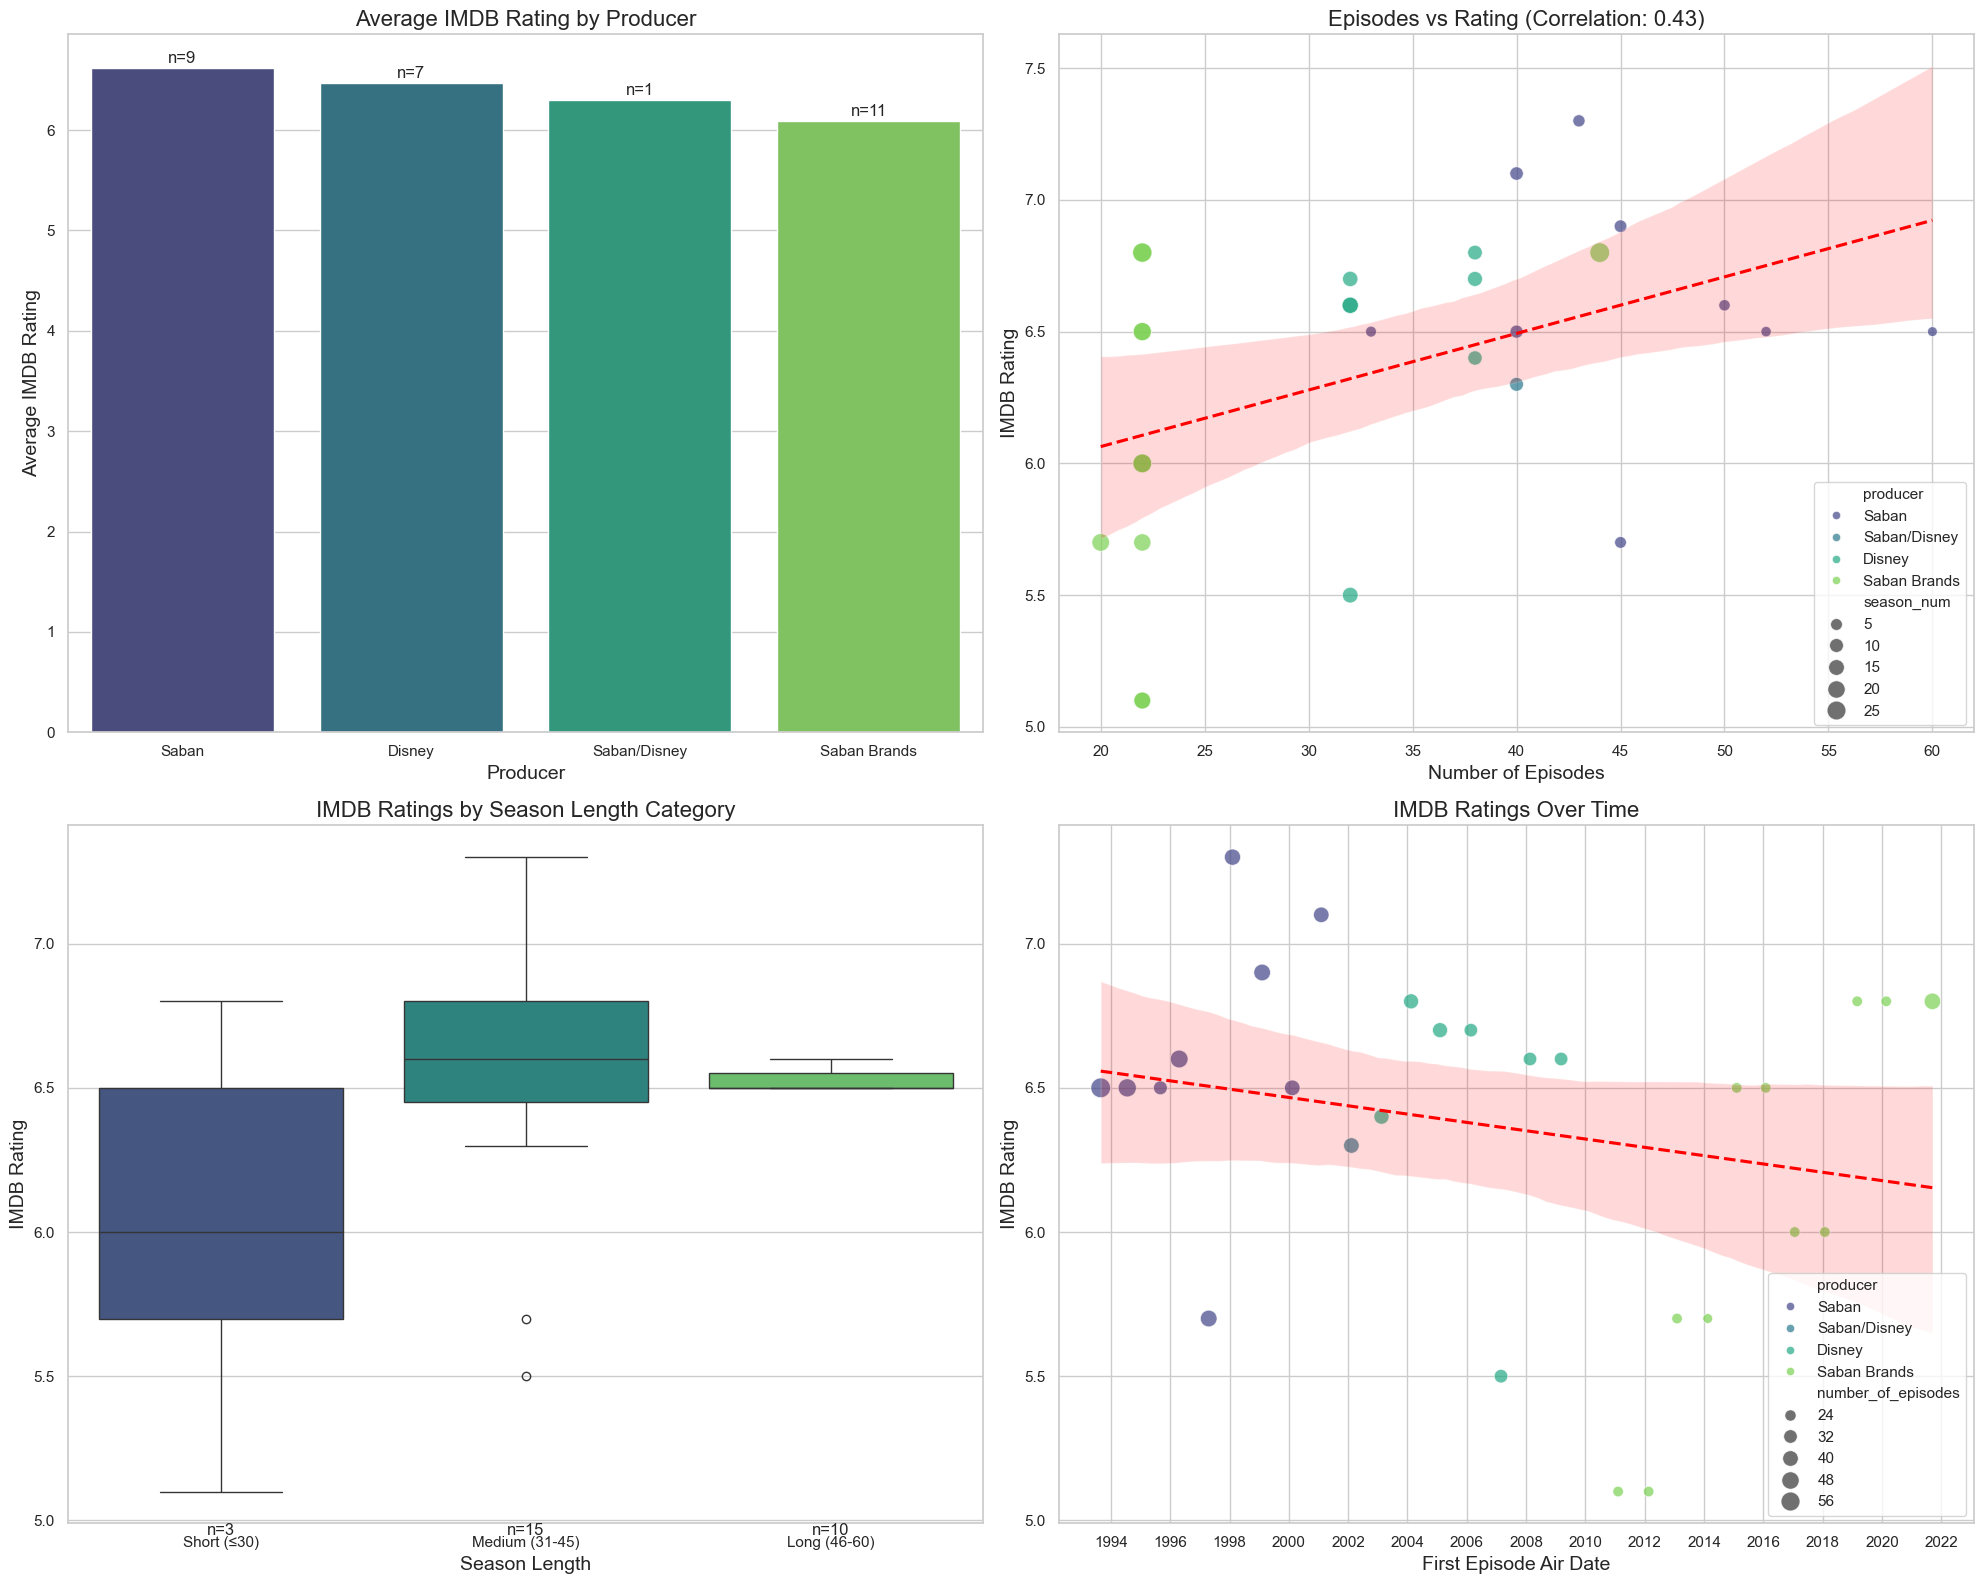

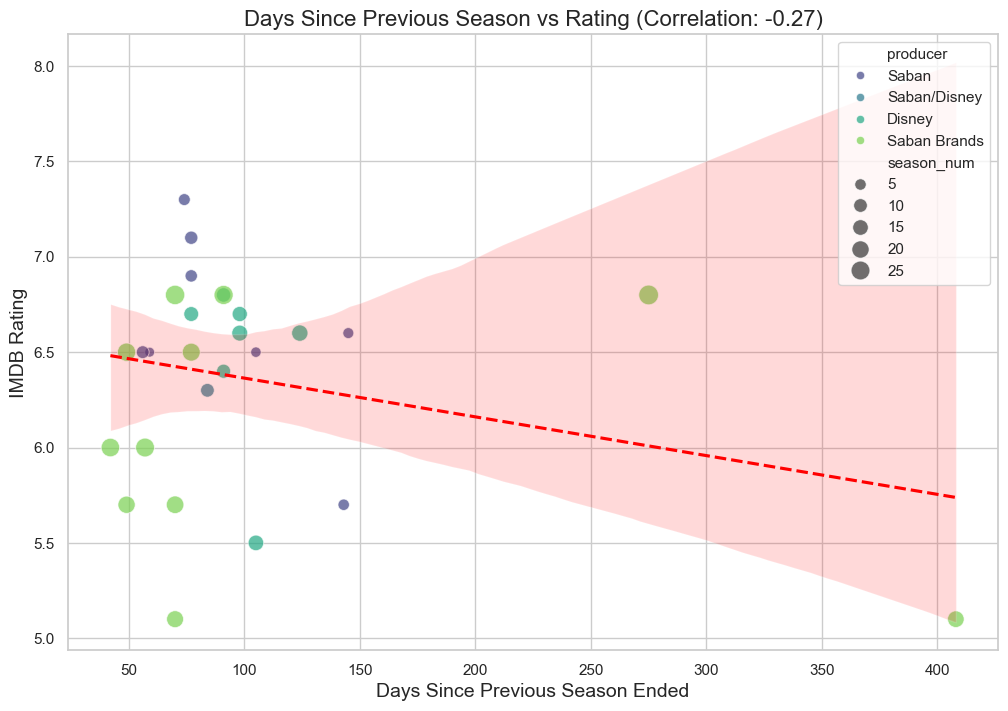

In [18]:
# Run the analysis
enhanced_df = analyze_popularity_factors(seasons_df)